In [1]:
import mxnet as mx

In [ ]:
# path='http://data.mxnet.io/models/imagenet-11k/'
# [mx.test_utils.download(path+'resnet-152/resnet-152-symbol.json'),
# mx.test_utils.download(path+'resnet-152/resnet-152-0000.params'),
# mx.test_utils.download(path+'synset.txt')]

In [32]:
# load model
sym, arg_params, aux_params = mx.model.load_checkpoint('resnet-152', epoch=0)
mod = mx.mod.Module(symbol=sym, context=mx.gpu(), label_names=None)
mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))], 
         label_shapes=mod._label_shapes)
mod.set_params(arg_params, aux_params, allow_missing=True)
with open('synset.txt','r') as f:
    labels = [l.rstrip() for l in f] 

In [33]:
def get_image(url, show=False):
    # download and show the image
    fname = mx.test_utils.download(url)
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    if img is None:
        return None
    if show:
        plt.imshow(img)
        plt.axis('off')
        
    # convert into  format (batch, RGB, width, height)
    img = cv2.resize(img, (224,224))
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2)
    img = img[np.newaxis, :]
    return img

def predict(url):
    img = get_image(url, show=True)
    # compute the predict probabilities
    mod.forward(Batch([mx.nd.array(img)]))
    prob = mod.get_outputs()[0].asnumpy()
    # print the top-5
    prob = np.squeeze(prob)
    a = np.argsort(prob)[::-1]
    for i in a[:5]:
        print('probability=%f, class=%s'%(prob[i], labels[i]))
    

In [34]:
# Predicting
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
# define a simple data batch
from collections import namedtuple
Batch = namedtuple('Batch', ['data'])

INFO:root:Cat-hd-wallpapers.jpg exists, skip to downloada


probability=0.695959, class=n02122948 kitten, kitty
probability=0.042496, class=n01323155 kit
probability=0.030121, class=n01318894 pet
probability=0.029757, class=n02122878 tabby, queen
probability=0.026040, class=n01322221 baby


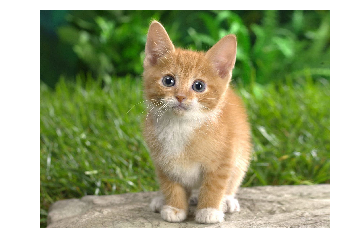

In [35]:
predict('http://writm.com/wp-content/uploads/2016/08/Cat-hd-wallpapers.jpg')

INFO:root:Pug-Cookie-1920x1080-1024x576.jpg exists, skip to downloada


probability=0.443745, class=n02110958 pug, pug-dog
probability=0.101610, class=n13905792 wrinkle, furrow, crease, crinkle, seam, line
probability=0.024097, class=n01318894 pet
probability=0.023298, class=n02083346 canine, canid
probability=0.023097, class=n02084732 pooch, doggie, doggy, barker, bow-wow


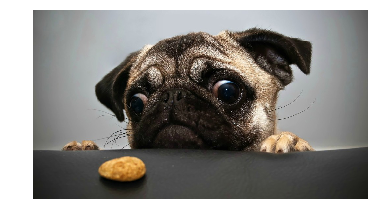

In [36]:
predict('http://thenotoriouspug.com/wp-content/uploads/2015/01/Pug-Cookie-1920x1080-1024x576.jpg')

In [37]:
### Feature extraction
# list the last 10 layers
all_layers = sym.get_internals()
all_layers.list_outputs()[-10:]

['bn1_moving_var',
 'bn1_output',
 'relu1_output',
 'pool1_output',
 'flatten0_output',
 'fc1_weight',
 'fc1_bias',
 'fc1_output',
 'softmax_label',
 'softmax_output']

In [38]:
fe_sym = all_layers['flatten0_output']
fe_mod = mx.mod.Module(symbol=fe_sym, context=mx.gpu(), label_names=None)
fe_mod.bind(for_training=False, data_shapes=[('data',(1,3,224,224))])
fe_mod.set_params(arg_params,aux_params)

In [39]:
img = get_image('http://writm.com/wp-content/uploads/2016/08/Cat-hd-wallpapers.jpg')
fe_mod.forward(Batch([mx.nd.array(img)]))
features = fe_mod.get_outputs()[0].asnumpy()
print(features)

INFO:root:Cat-hd-wallpapers.jpg exists, skip to downloada


[[ 0.4337692   1.01670492  0.13611683 ...,  1.48048747  0.14093943
   0.6597349 ]]


## fine tune with Resnet152 to Train MNIST

In [10]:
import mxnet as mx
sym, arg_params, aux_params = mx.model.load_checkpoint('resnet-152', epoch=0)

# 找出输出层的名字 flatten0_output
all_layers = sym.get_internals()
all_layers.list_outputs()[-10:]

['bn1_moving_var',
 'bn1_output',
 'relu1_output',
 'pool1_output',
 'flatten0_output',
 'fc1_weight',
 'fc1_bias',
 'fc1_output',
 'softmax_label',
 'softmax_output']

In [11]:
net = all_layers['flatten0_output']
net = mx.sym.FullyConnected(data=net, num_hidden=10, name='fc')
net = mx.sym.SoftmaxOutput(data=net, name='softmax')

In [12]:
new_args = dict({k:arg_params[k] for k in arg_params if 'fc' not in k})

In [14]:
mx.viz.plot_network(net).view()

'plot.gv.pdf'

In [25]:
mnist = mx.test_utils.get_mnist()
batch_size = 256
train_iter = mx.io.NDArrayIter(data=mnist['train_data'],
                               label=mnist['train_label'],
                               batch_size=batch_size,
                               shuffle=True)

eval_iter = mx.io.NDArrayIter(data=mnist['test_data'],
                              label=mnist['test_label'], 
                              batch_size=batch_size, 
                              shuffle=False)

INFO:root:train-labels-idx1-ubyte.gz exists, skip to downloada
INFO:root:train-images-idx3-ubyte.gz exists, skip to downloada
INFO:root:t10k-labels-idx1-ubyte.gz exists, skip to downloada
INFO:root:t10k-images-idx3-ubyte.gz exists, skip to downloada


In [30]:
import logging
logging.getLogger().setLevel(logging.DEBUG)
fine_tune_modle = mx.mod.Module(symbol=net, context=mx.gpu())
fine_tune_modle.fit(train_data=train_iter, 
                    eval_data=eval_iter, 
                    optimizer='sgd',
                    num_epoch=20,
                    batch_end_callback=mx.callback.Speedometer(batch_size, 256))

INFO:root:Epoch[0] Train-accuracy=0.903939
INFO:root:Epoch[0] Time cost=31.509
INFO:root:Epoch[0] Validation-accuracy=0.971582
INFO:root:Epoch[1] Train-accuracy=0.987184
INFO:root:Epoch[1] Time cost=31.392
INFO:root:Epoch[1] Validation-accuracy=0.985938
INFO:root:Epoch[2] Train-accuracy=0.993700
INFO:root:Epoch[2] Time cost=31.560
INFO:root:Epoch[2] Validation-accuracy=0.987012
INFO:root:Epoch[3] Train-accuracy=0.996210
INFO:root:Epoch[3] Time cost=31.590
INFO:root:Epoch[3] Validation-accuracy=0.987793
INFO:root:Epoch[4] Train-accuracy=0.997507
INFO:root:Epoch[4] Time cost=31.508
INFO:root:Epoch[4] Validation-accuracy=0.984961
INFO:root:Epoch[5] Train-accuracy=0.996659
INFO:root:Epoch[5] Time cost=31.483
INFO:root:Epoch[5] Validation-accuracy=0.980273
INFO:root:Epoch[6] Train-accuracy=0.997473
INFO:root:Epoch[6] Time cost=31.631
INFO:root:Epoch[6] Validation-accuracy=0.988574
INFO:root:Epoch[7] Train-accuracy=0.998105
INFO:root:Epoch[7] Time cost=32.446
INFO:root:Epoch[7] Validation-ac

## prediction

In [31]:
test_iter = mx.io.NDArrayIter(data=mnist['test_data'], label=mnist['test_label'], batch_size=batch_size)
acc = mx.metric.Accuracy()
fine_tune_modle.score(test_iter, acc)
print(acc)

EvalMetric: {'accuracy': 0.99228515625000002}
